In [3]:
from MorseComplex import *
from matplotlib import colors, cm
import matplotlib.pyplot as plt
import scipy.io
import itertools
from skimage import io, filters, morphology, restoration, feature, transform
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from itertools import cycle
import sklearn.cluster
from sklearn.preprocessing import MinMaxScaler

import nglpy
import topopy
import pdir
import time
import os

In [4]:
def show_image(image):
    plt.figure(num=None, dpi=200)
    img = plt.imshow(image, cmap=plt.cm.Greys, norm=colors.LogNorm(vmin=image.min(), vmax=image.max()),)
    plt.colorbar(img)

# Investigating Mandatory Critical Fields

In [5]:
class Path(list):
    def add(self, item):
        self.append(item)
        

def plot_colorline(x,y,c):
    c = cm.Greys((c-np.min(c))/(np.max(c)-np.min(c)))
    ax = plt.gca()
    for i in np.arange(len(x)-1):
        ax.plot([x[i],x[i+1]], [y[i],y[i+1]], c=c[i])
    return        

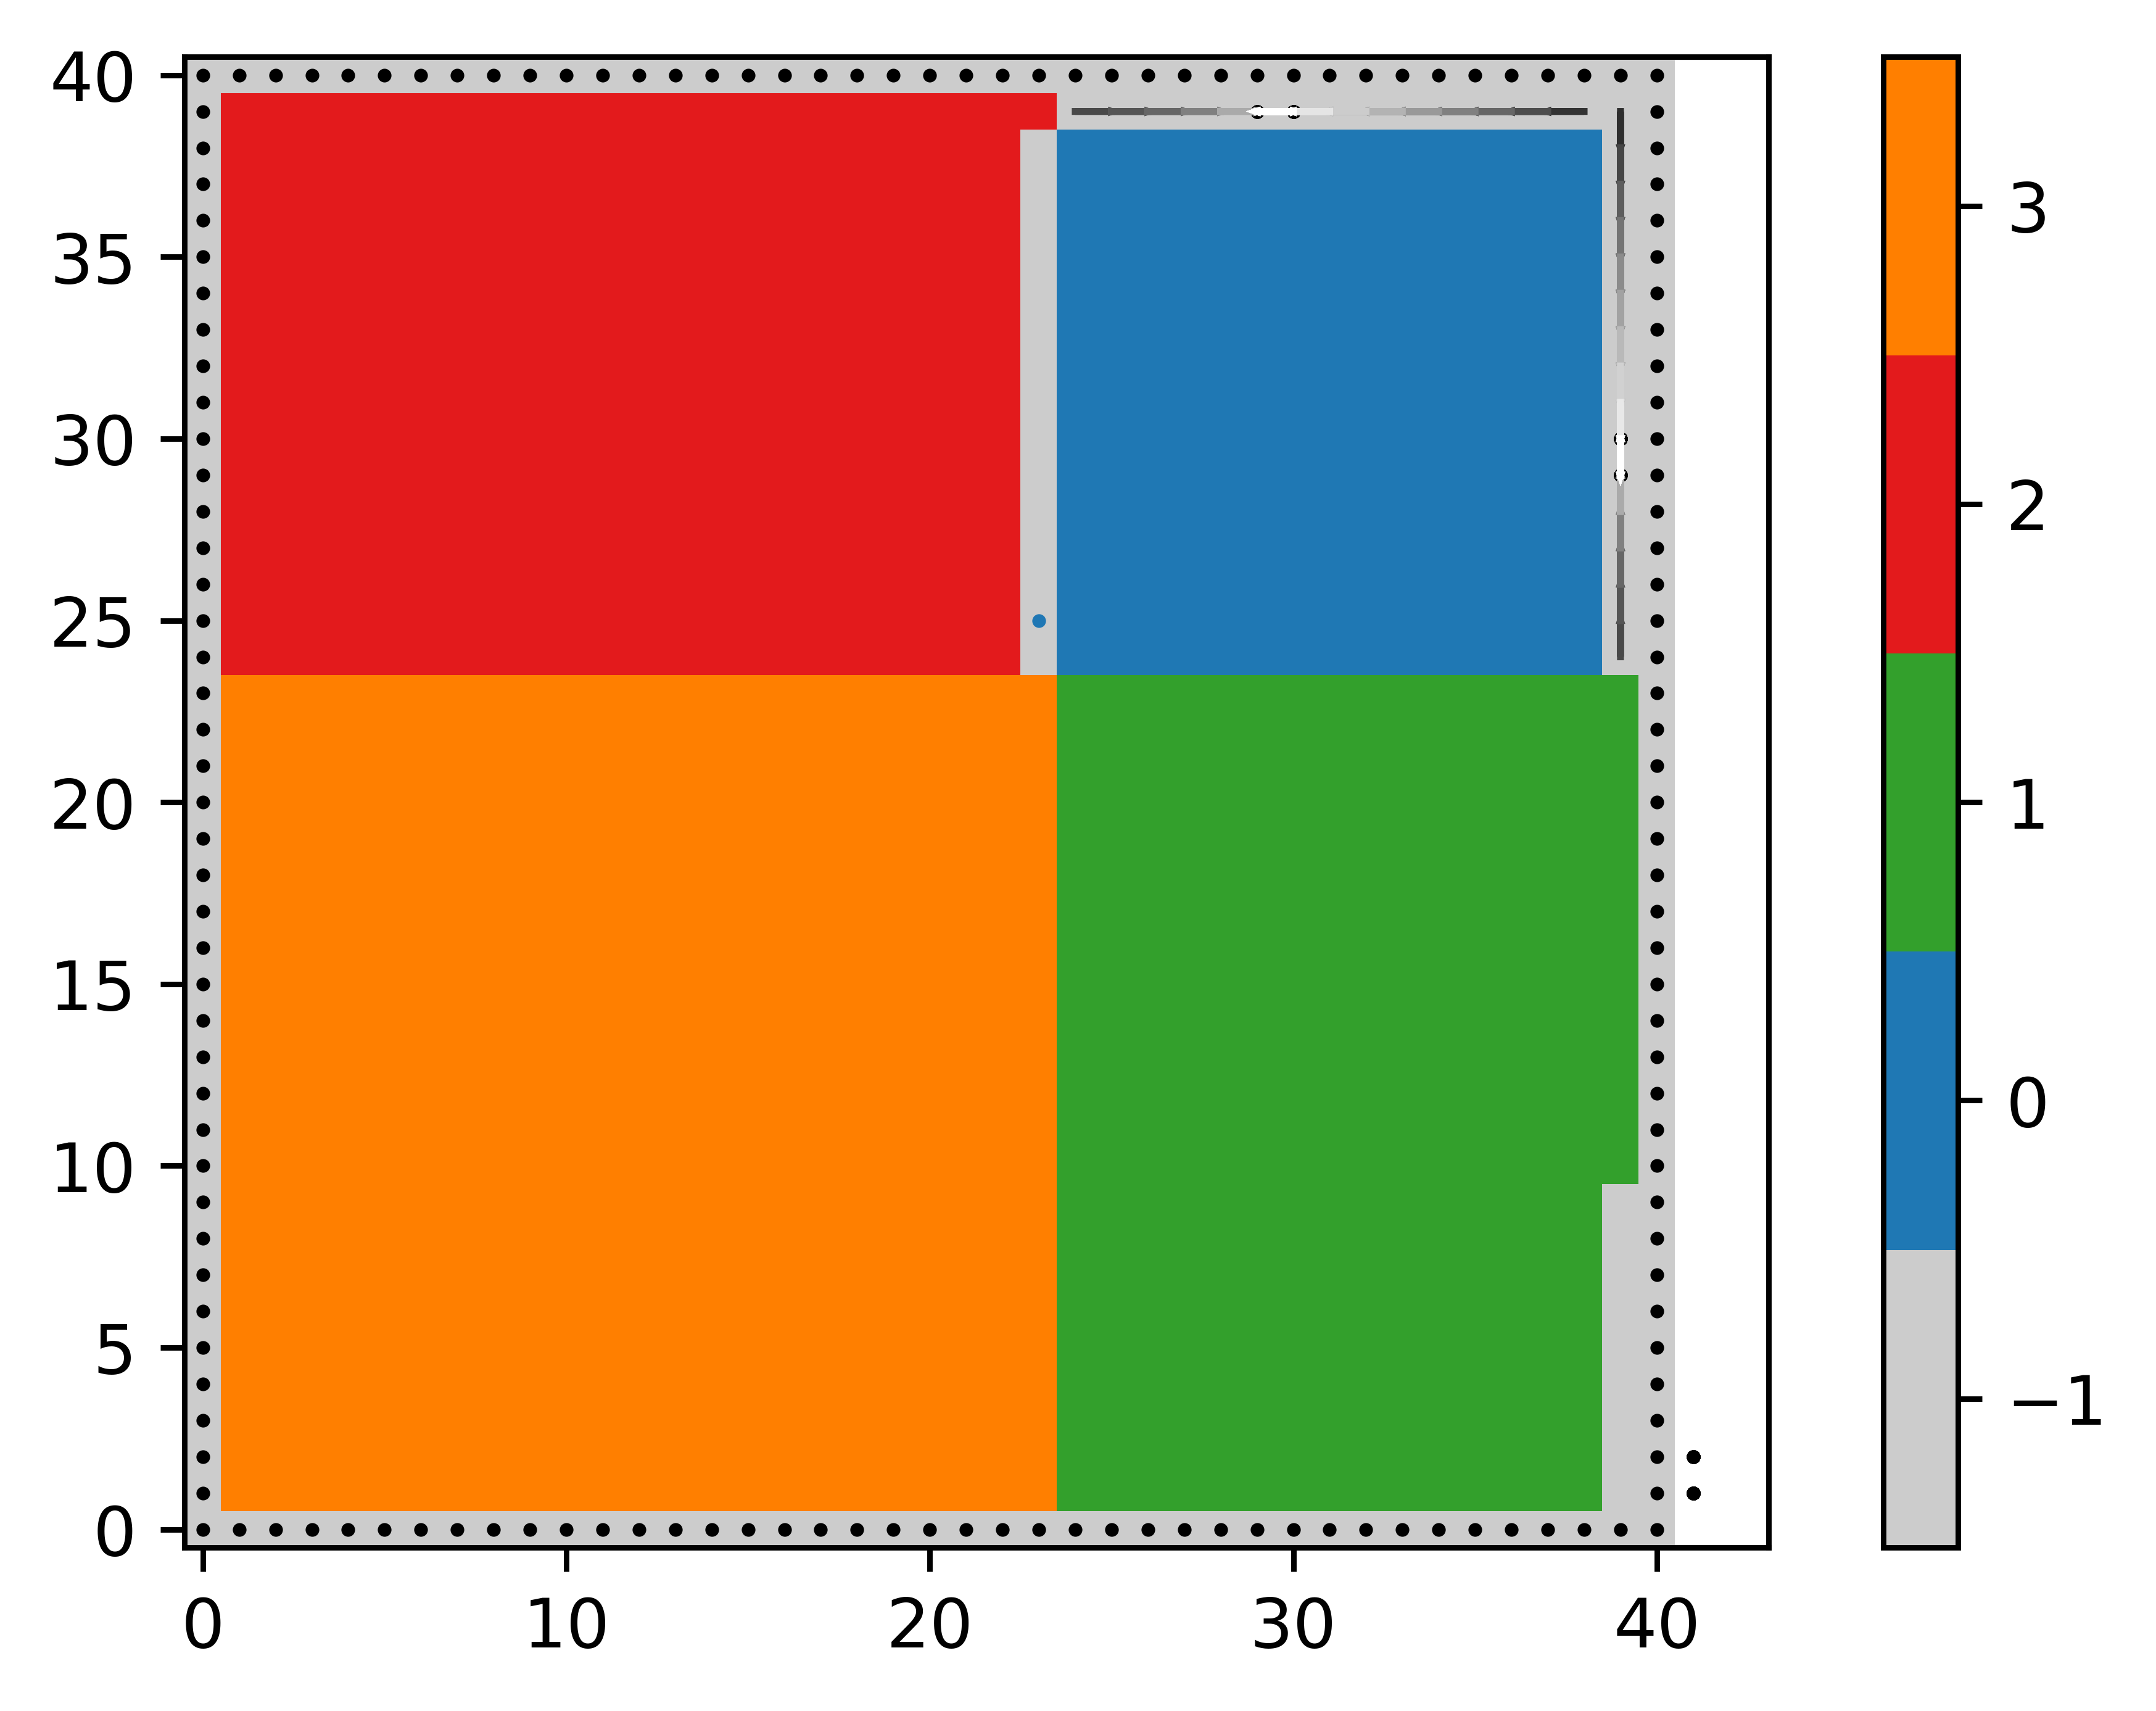

In [10]:
xComponent = scipy.io.loadmat("../data/xComponent")["discreteGradProbX"]
yComponent = scipy.io.loadmat("../data/yComponent")["discreteGradProbY"]
mandatoryMaxima = scipy.io.loadmat("../data/mandatoryMax")["mandatoryMax"]

mc = MorseComplex2D(xComponent, yComponent, mandatoryMaxima)

flow = mc.maxFlow
# print(np.unique(flow))
flow[np.where(flow < 0)] = -1
uniqueCount = len(np.unique(flow))

colorList = [
    "#cccccc",
    "#1f78b4",
    "#33a02c",
    "#e31a1c",
    "#ff7f00",
    "#6a3d9a",
    "#b15928",
    "#a6cee3",
    "#b2df8a",
    "#fb9a99",
    "#fdbf6f",
    "#cab2d6",
    "#ffff99",
]

########################################################################

cmap = colors.ListedColormap(colorList[:uniqueCount])
bounds = np.unique(flow) - 0.5
bounds = bounds.tolist()
bounds.append(bounds[-1]+1)
plt.figure(dpi=800)
img = plt.imshow(flow, cmap=cmap, interpolation="nearest", origin="lower")
plt.colorbar(img, cmap=cmap, ticks=np.unique(flow), boundaries=bounds)

########################################################################

# colorCycle = itertools.cycle(colorList)
# colorMap = {}

# ids = {}
# for i in np.unique(mc.maxFlow):
#     colorMap[i] = next(colorCycle)
#     ids[i] = []
#     for row, vals in enumerate(mc.maxFlow):
#         for col, val in enumerate(vals):
#             if val == i:
#                 ids[i].append([col, row])

# for key, values in ids.items():
#     positions = np.array(values)
#     plt.scatter(positions[:, 0], positions[:, 1], c=colorMap[key])

flow = mc.maxFlow
touched = set()
for j, row in enumerate(flow):
    for i, col in enumerate(row):
        if col == -1:
            touched = Path()
            destination = mc.trace(i, j, touched)
            xs = []
            ys = []
            color = 0
            x = destination // flow.shape[1]
            y = destination % flow.shape[1]
            plt.scatter([x], [y], color="0.0", s = 1)

            for idx in touched:
                xs.append(idx // flow.shape[1])
                ys.append(idx % flow.shape[1])
                color += 1. / len(touched)
                if len(xs) > 1:
                    plt.arrow(xs[-2], ys[-2], xs[-1]-xs[-2], ys[-1]-ys[-2], color=str(color))


plt.scatter([23], [25], s=1)
plt.show()

In [11]:
i=23
j=25
touched = Path()
destination = mc.trace(i, j, touched)
print(destination, i*41+j, touched)

1682 968 [968]


In [12]:
1682 // 41, 1682 % 41

(41, 1)

In [13]:
mc.uf.Find(968) - 1680

2

Possibly a bug in what I am doing here related to the offset I add to ensure no collisions with real indices.

In [14]:
from mpl_toolkits.basemap import Basemap
from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

In [15]:
def plot_map_realization(latlon, grid):
    X, Y = massage_data(grid)
    h, w = grid.shape

    graph = nglpy.Graph(index=None, max_neighbors=10, relaxed=False, beta=1, p=2.)
    tmc = topopy.MorseComplex(graph=graph,
                              gradient='steepest',
                              normalization='feature')
    tmc.build(X, Y)

    partitions = tmc.get_partitions(0.1)
    keys = partitions.keys()

    keyMap = {}
    for i,k in enumerate(keys):
        keyMap[k] = i

    colorList = [
        "#1f78b4",
        "#33a02c",
        "#e31a1c",
        "#ff7f00",
        "#6a3d9a",
        "#b15928",
        "#a6cee3",
        "#b2df8a",
        "#fb9a99",
        "#fdbf6f",
        "#cab2d6",
        "#ffff99",
        "#cccccc",
    ]
    
    ccycle = cycle(colorList)

    uniqueCount = len(keys)
    usedColors = []
    for i,c in zip(range(uniqueCount), ccycle):
        usedColors.append(c)
    cmap = colors.ListedColormap(usedColors)
    bounds = np.array([keyMap[k] for k in keys]) - 0.5
    bounds = bounds.tolist()
    bounds.append(bounds[-1]+1)
    plt.figure(dpi=800)

    color_mesh = np.zeros((w, h))
    for key, indices in partitions.items():
        for idx in indices:
            color_mesh[idx // w, idx % w] = keyMap[key]

    fig = plt.figure(figsize=(8, 8), edgecolor='w')
    min_latitude = -10
    max_latitude = 90
    min_longitude = 0
    max_longitude = 100
    bmap = Basemap(projection='cyl',
                llcrnrlat=np.min(latlon[:,:,0]), urcrnrlat=np.max(latlon[:,:,0]),
                llcrnrlon=np.min(latlon[:,:,1]), urcrnrlon=np.max(latlon[:,:,1]), )
    draw_map(bmap)
    bmap.drawcoastlines(linewidth=0.25)
    bmap.drawcountries(linewidth=0.25)            
    img = bmap.imshow(color_mesh.T, cmap=cmap, interpolation="nearest", origin="lower", alpha=0.25)
    plt.colorbar(img, cmap=cmap, ticks=[range(uniqueCount)], boundaries=bounds)
    bmap.contour(latlon[:,:,1], latlon[:,:,0], grid, cmap=cm.Greys, latlon=True)

In [16]:
uncertain_realizations = np.load("precipitation_2019-02-08T00:00:00.npy")
latlon = np.load("latlon_2019-02-08T00:00:00.npy")
mean_realization = np.mean(uncertain_realizations, axis=2)

my_dir = "precipitation_forecast"
if not os.path.exists(my_dir):
    os.makedirs(my_dir)

FileNotFoundError: [Errno 2] No such file or directory: 'precipitation_2019-02-08T00:00:00.npy'

In [ ]:
fig = plt.figure(figsize=(8, 8), edgecolor='w')
bmap = Basemap(projection='cyl',
#             llcrnrlat=min_latitude, urcrnrlat=max_latitude,
#             llcrnrlon=min_longitude, urcrnrlon=max_longitude, )
            llcrnrlat=np.min(latlon[:,:,0]), urcrnrlat=np.max(latlon[:,:,0]),
            llcrnrlon=np.min(latlon[:,:,1]), urcrnrlon=np.max(latlon[:,:,1]), )
draw_map(bmap)
bmap.drawcoastlines(linewidth=0.25)
bmap.drawcountries(linewidth=0.25)
img = bmap.imshow(uncertain_realizations[:,:,0].T, interpolation="nearest", origin="lower", alpha=0.5)
contours = bmap.contour(latlon[:,:,1], latlon[:,:,0], uncertain_realizations[:,:,0], cmap=cm.Greys, latlon=True)
cb = plt.colorbar(img)
cb.add_lines(contours)

In [ ]:
plot_map_realization(latlon, uncertain_realizations[:,:,0])

## Visualize Realizations and Mean

In [ ]:
for i in range(uncertain_realizations.shape[2]):
    plot_map_realization(latlon, uncertain_realizations[:,:,i])
    plt.savefig("{}/realization_{}.png".format(my_dir, i), bbox_inches='tight')

In [ ]:
plot_map_realization(latlon, mean_realization)
plt.savefig("{}/realization_mean.png".format(my_dir), bbox_inches='tight')

## Determine Survival Count to see if there are Clear Uncertain Regions

In [ ]:
all_counts = np.zeros(uncertain_realizations[:,:,0].shape)
all_weighted_counts = np.zeros(uncertain_realizations[:,:,0].shape)
for i in range(uncertain_realizations.shape[2]):
# for i in range(1):
    counts, weighted_counts = count_persistence(uncertain_realizations[:,:,i])
    all_counts += counts
    all_weighted_counts += weighted_counts

In [ ]:
fig = plt.figure(figsize=(8, 8), edgecolor='w')
m = Basemap(projection='cyl',
            llcrnrlat=np.min(latlon[:,:,0]), urcrnrlat=np.max(latlon[:,:,0]),
            llcrnrlon=np.min(latlon[:,:,1]), urcrnrlon=np.max(latlon[:,:,1]), )
draw_map(m)
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)

img = m.imshow(all_counts.T, cmap=cm.Greys, alpha=0.25)
plt.colorbar(img)
k = (np.max(all_counts) + np.min(all_counts)) / 2.
print(k)
bmap.contour(latlon[:,:,1], latlon[:,:,0], all_counts, levels=[k], colors='#FFFF00', latlon=True)
plt.savefig("{}/survival_count.png".format(my_dir), bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(8, 8), edgecolor='w')
m = Basemap(projection='cyl',
            llcrnrlat=np.min(latlon[:,:,0]), urcrnrlat=np.max(latlon[:,:,0]),
            llcrnrlon=np.min(latlon[:,:,1]), urcrnrlon=np.max(latlon[:,:,1]), )
draw_map(m)
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)
img2 = m.imshow(all_weighted_counts.T, cmap=cm.Greys)
plt.colorbar(img2)
k = (np.max(all_weighted_counts) + np.min(all_weighted_counts)) / 2.
print(k)
bmap.contour(latlon[:,:,1], latlon[:,:,0], all_weighted_counts, levels=[k], colors='#FFFF00', latlon=True)
plt.savefig("{}/weighted_survival_count.png".format(my_dir), bbox_inches='tight')

## Look at the variance of the weighted count to highlight highly varying regions

In [ ]:
mean_images = []
max_radius = 5

image = (all_weighted_counts - np.min(all_weighted_counts)) / (np.max(all_weighted_counts) - np.min(all_weighted_counts))
eps=1e-16
for i in range(1, max_radius):
    mean_images.append(filters.rank.mean(image, selem=morphology.disk(i)))

image = 255*image
variance_images = []
eps=1e-16
for i, mean_image in enumerate(mean_images):
    variance_images.append(np.power(image-mean_image,2)+eps)
    show_image(variance_images[-1].T)
    plt.gca().set_title("Variance r={}".format(i))

plt.savefig("{}/weighted_surival_count_variance.png".format(my_dir), bbox_inches='tight')

## Does the Persistence Chart tell us anything?

In [ ]:
plt.figure(dpi=800)

for i in range(uncertain_realizations.shape[2]):
    graph = nglpy.Graph(index=None, max_neighbors=10, relaxed=False, beta=1, p=2.)
    tmc = topopy.MorseComplex(graph=graph,
                              gradient='steepest',
                              normalization='feature')

    X, Y = massage_data(uncertain_realizations[:, :, i])
    tmc.build(X, Y)
    ps = [0]

    count = len(np.unique(list(tmc.get_partitions(0).keys())))
    counts = [count]
    eps = 1e-6
    for i, p in enumerate(tmc.persistences):
        ps.append(p)
        counts.append(count)
        count = len(np.unique(list(tmc.get_partitions(p+eps).keys())))
        ps.append(p)
        counts.append(count)
    plt.plot(ps, counts, alpha=0.2, c='#1f78b4')

ax = plt.gca()
ax.set_ylim(0, 50)
# plt.axhline(2, 0.10, 0.20, linestyle='dashed', color='#000000')
plt.show()
plt.savefig("{}/composite_persistence_charts.png".format(my_dir), bbox_inches='tight')

## Set n_clusters based on above analysis and try to cluster the data

In [ ]:
max_points = list()
max_member = list()

for i in range(uncertain_realizations.shape[2]):
    graph = nglpy.Graph(index=None, max_neighbors=10, relaxed=False, beta=1, p=2.)
    tmc = topopy.MorseComplex(graph=graph,
                              gradient='steepest',
                              normalization='feature')

    X, Y = massage_data(uncertain_realizations[:, :, i])
    tmc.build(X, Y)

    for key in tmc.get_partitions(20).keys():
        max_points.append((int(X[key, 0]), int(X[key, 1])))
        max_member.append(i)

In [ ]:
plt.figure(dpi=800)
maxima = np.array(max_points)
maxima = MinMaxScaler().fit_transform(maxima)
clustering = sklearn.cluster.MeanShift().fit(maxima)
clustering = sklearn.cluster.MiniBatchKMeans(n_clusters=7).fit(maxima)
# clustering = sklearn.cluster.AgglomerativeClustering(n_clusters=6).fit(maxima)
# clustering = sklearn.cluster.KMeans(n_clusters=6).fit(maxima)
# clustering = sklearn.cluster.DBSCAN(eps=0.3, min_samples=3).fit(maxima)
# clustering = sklearn.cluster.SpectralClustering(n_clusters=6).fit(maxima)
unique_labels = np.unique(clustering.labels_)
maxima_map = {}
colorList = [
        "#1f78b4",
        "#33a02c",
        "#e31a1c",
        "#ff7f00",
        "#6a3d9a",
        "#b15928",
        "#a6cee3",
        "#b2df8a",
        "#fb9a99",
        "#fdbf6f",
        "#cab2d6",
        "#ffff99",
        "#cccccc",
    ]
    
ccycle = cycle(colorList)

color_map = {}
for label in unique_labels:
    color_map[label] = next(ccycle)

my_colors = []
for i in range(len(maxima)):
    my_colors.append(color_map[clustering.labels_[i]])
    maxima_map[max_points[i]] = clustering.labels_[i]
    r = 0.025
    x = r*np.cos(max_member[i]/uncertain_realizations.shape[2]*2*np.pi)
    y = r*np.sin(max_member[i]/uncertain_realizations.shape[2]*2*np.pi)
    eps = np.array([x-0.01, y-0.02])
    plt.annotate("{}".format(max_member[i]), maxima[i,:]+eps)
_ = plt.scatter(maxima[:,0], maxima[:,1], c=my_colors)

In [ ]:
def assignments(grid):
    X, Y = massage_data(grid)
    h, w = grid.shape

    graph = nglpy.Graph(index=None, max_neighbors=10, relaxed=False, beta=1, p=2.)
    tmc = topopy.MorseComplex(graph=graph,
                              gradient='steepest',
                              normalization='feature')
    tmc.build(X, Y)

    correct_p = 20
    partitions = tmc.get_partitions(p)
            
    field = np.zeros(Y.shape, dtype=int)
    for k, v in partitions.items():
        field[v] = maxima_map[(int(X[k, 0]), int(X[k, 1]))]

    
    return field.reshape(grid.shape), correct_p

In [ ]:
ps = []
fields = []
for i in range(uncertain_realizations.shape[2]):
    field, p = assignments(uncertain_realizations[:,:,i])
    ps.append(p)
    fields.append(field)
    
ps = np.array(ps)
fields = np.array(fields)
print(np.min(ps), np.max(ps), np.mean(ps), np.std(ps))

## Look at the probabilities of each pixel flowing to the local maxima clusters

In [ ]:
num_partitions = len(np.unique(fields[0]))
shape = (num_partitions,) + fields[0].shape
label_images = np.zeros(shape)

dim1 = int(np.ceil(np.sqrt(num_partitions)))
dim2 = int(np.floor(num_partitions/dim1+0.5))
fig, axes = plt.subplots(dim1, dim2, tight_layout=True)

axes = axes.flatten()

for i in range(num_partitions):
    test_image = (fields == i)
    label_images[i] = np.sum(test_image, axis=0)
    img = axes[i].imshow(label_images[i])
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
for i in range(num_partitions, dim1*dim2):
    axes[i].set_visible(False)

plt.savefig("{}/partition_probabilities.png".format(my_dir), bbox_inches='tight')

# fig.colorbar(img, ax=axes.ravel().tolist())

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(img, cax=cbar_ax)

## Color Blended Example

In [ ]:
color_list = [[141,211,199], [255,255,179], [190,186,218],
              [251,128,114], [128,177,211], [253,180,98],
              [179,222,105], [252,205,229], [217,217,217]]
# color_list = [[105,239,123], [149,56,144], [192,222,164],
#                 [14,80,62], [153,222,249], [24,81,155],
#                 [218,185,255], [66,30,200], [183,211,33]]
# color_list = [[251,180,174],[179,205,227],[204,235,197],
#               [222,203,228],[254,217,166],[255,255,204],
#               [229,216,189],[253,218,236],[242,242,242]]

ccycle = cycle(color_list)

colored_images = []
for i, c in zip(range(num_partitions), ccycle):
    colored_image = np.zeros(label_images[0].shape + (4,))
    colored_image[:,:,0] = c[0]/255.
    colored_image[:,:,1] = c[1]/255.
    colored_image[:,:,2] = c[2]/255.
    colored_images.append(colored_image)

for i, label_image in enumerate(label_images):
    colored_images[i][:,:, 3] = label_image / uncertain_realizations.shape[2]

for i in range(num_partitions):
    plt.figure()
    plt.imshow(colored_images[i])

In [ ]:
composite_image = 255*np.ones(colored_images[0].shape)[:,:,:-1]
for colored_image in colored_images:
    composite_image = overlay_alpha_image_precise(composite_image, 255*colored_image, 1.)
plt.figure(dpi=300)
plt.imshow(composite_image)
plt.savefig("{}/composite_probabilities.png".format(my_dir), bbox_inches='tight')

## Lastly, try overlaying contours

In [ ]:
for i, color in zip(range(num_partitions), ccycle):
    my_color = "#{}{}{}".format(*[hex(c).split('x')[-1] for c in color])
    plt.figure(dpi=100)
    plt.contourf(colored_images[i][:,:, 3].T, levels=[0.05, 1.0], colors=my_color, alpha=0.5)
    plt.contour(colored_images[i][:,:, 3].T, levels=[0.05, 0.2, 0.4, 0.6, 0.8, 0.98], colors=my_color, linewidths=[1, 0.5, 0.5, 0.5, 0.5, 0.5], linestyles=['solid','dashed','dashed','dashed','dashed','dashed'])
    plt.gca().set_ylim(colored_images[i].shape[1], 0)

In [ ]:
plt.figure(dpi=300)
for i, color in zip(range(num_partitions), ccycle):
    my_color = "#{}{}{}".format(*[hex(c).split('x')[-1] for c in color])
    plt.contourf(colored_images[i][:,:, 3], levels=[1e-6, 1], colors=my_color, alpha=0.5)
    plt.contour(colored_images[i][:,:, 3], levels=[0.0, 0.5, 1], colors=my_color, linewidths=[1, 0.5, 1.0], linestyles=['solid','dashed','solid'])
plt.gca().set_ylim(colored_images[i].shape[1], 0)
plt.figure(dpi=300)

In [ ]:
plt.figure(dpi=300)
for i, color in zip(range(num_partitions), ccycle):
    my_color = "#{}{}{}".format(*[hex(c).split('x')[-1] for c in color])
    plt.contourf(colored_images[i][:,:, 3], levels=[0.99999, 1], colors=my_color, alpha=0.5)
    plt.contour(colored_images[i][:,:, 3], levels=[0.0, 0.5, 1], colors=my_color, linewidths=[1, 0.5, 1.0], linestyles=['solid','dashed','solid'])
_ = plt.gca().set_ylim(colored_images[i].shape[1], 0)